In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 18})
from joblib import delayed, Parallel
from collections import defaultdict, OrderedDict

from utils.generic import init_params
from main.seir.optimiser import Optimiser
from models.seir.seir_testing import SEIR_Testing
from data.processing import get_district_time_series
from data.dataloader import get_covid19india_api_data

## Load covid19 data

In [3]:
dataframes = get_covid19india_api_data()

In [4]:
dataframes.keys()

dict_keys(['df_tested', 'df_statewise', 'df_india_time_series', 'df_districtwise', 'df_raw_data', 'df_raw_data_2', 'df_travel_history', 'df_resources'])

In [7]:
regions = [('Delhi', ''), ('Karnataka', 'Bengaluru'), ('Maharashtra', 'Mumbai'), ('Maharashtra', 'Pune'), ('Gujarat', 'Ahmadabad'), ('Rajasthan', 'Jaipur')]
state, district = regions[1]
df_district = get_district_time_series(dataframes, state=state, district=district)

## Create train-val splits

In [8]:
df_train = df_district.iloc[:-5, :]
df_val = df_district.iloc[-5:, :]

In [9]:
df_train, df_val

(         date  total_infected
 0  2020-03-09               1
 1  2020-03-10               4
 2  2020-03-11               4
 3  2020-03-12               5
 4  2020-03-13               5
 5  2020-03-14               5
 6  2020-03-15               5
 7  2020-03-16               5
 8  2020-03-17               8
 9  2020-03-18              11
 10 2020-03-19              11
 11 2020-03-20              11
 12 2020-03-21              14
 13 2020-03-22              17
 14 2020-03-23              23
 15 2020-03-24              24
 16 2020-03-25              32
 17 2020-03-26              33
 18 2020-03-27              37
 19 2020-03-28              39
 20 2020-03-29              39
 21 2020-03-30              39
 22 2020-03-31              43
 23 2020-04-01              46
 24 2020-04-02              46
 25 2020-04-03              46
 26 2020-04-04              50
 27 2020-04-05              50
 28 2020-04-06              51
 29 2020-04-07              54
 30 2020-04-08              55
 31 2020

## Loss Calculation Functions

In [10]:
def _calc_rmse(y_pred, y_true, log=True):
    if log:
        y_true = np.log(y_true)
        y_pred = np.log(y_pred)
    loss = np.sqrt(np.mean((y_true - y_pred)**2))
    return loss

def _calc_mape(y_pred, y_true):
    y_pred = y_pred[y_true > 0]
    y_true = y_true[y_true > 0]

    ape = np.abs((y_true - y_pred + 0) / y_true) *  100
    loss = np.mean(ape)
    return loss

def calc_loss_dict(states_time_matrix, df, method='rmse', rmse_log=False):
    pred_hospitalisations = states_time_matrix[6] + states_time_matrix[7] + states_time_matrix[8]
    pred_recoveries = states_time_matrix[9]
    pred_fatalities = states_time_matrix[10]
    pred_infectious_unknown = states_time_matrix[2] + states_time_matrix[4]
    pred_total_cases = pred_hospitalisations + pred_recoveries + pred_fatalities
    
    if method == 'rmse':
        if rmse_log:
            calculate = lambda x, y : _calc_rmse(x, y)
        else:
            calculate = lambda x, y : _calc_rmse(x, y, log=False)
    
    if method == 'mape':
            calculate = lambda x, y : _calc_mape(x, y)
    
    losses = {}
#     losses['hospitalised'] = calculate(pred_hospitalisations, df['Hospitalised'])
#     losses['recovered'] = calculate(pred_recoveries, df['Recovered'])
#     losses['fatalities'] = calculate(pred_fatalities, df['Fatalities'])
#     losses['active_infections'] = calculate(pred_infectious_unknown, df['Active Infections (Unknown)'])
    losses['total'] = calculate(pred_total_cases, df['total_infected'])
    
    return losses

def calc_loss(states_time_matrix, df, method='rmse', rmse_log=False):
    losses = calc_loss_dict(states_time_matrix, df, method, rmse_log)
#     loss = losses['hospitalised'] + losses['recovered'] + losses['total'] + losses['active_infections']
    loss = losses['total']
    return loss

## Set priors for parameters of interest

In [11]:
## assuming uniform priors, following dictionary contains the ranges
prior_ranges = OrderedDict()
prior_ranges['R0'] = (1, 3)#(1.6, 3)
prior_ranges['T_inc'] = (1, 5) #(4, 5)
prior_ranges['T_inf'] = (1, 4) #(3, 4)
prior_ranges['T_recov_severe'] = (9, 20)
prior_ranges['P_severe'] = (0.3, 0.99)
prior_ranges['intervention_amount'] = (0.3, 1)
prior_ranges['sigma'] = (0, 1)

def param_init(prior_ranges):
    theta = defaultdict()
    for key in prior_ranges:
        theta[key] = np.random.uniform(prior_ranges[key][0], prior_ranges[key][1])
        
    return theta

## Proposal function to sample theta_new given theta_old

In [12]:
proposal_sigmas = OrderedDict()
for key in prior_ranges:
    proposal_sigmas[key] = 0.025 * (prior_ranges[key][1] - prior_ranges[key][0])

def proposal(theta_old, proposal_sigmas):
    theta_new = np.random.normal(loc=[*theta_old.values()], scale=[*proposal_sigmas.values()])
    return dict(zip(theta_old.keys(), theta_new))


## Log Likelihood and Prior

In [13]:
def log_likelihood(theta, df_train, fit_days=10):
    if (np.array([*theta.values()]) < 0).any():
        return -np.inf
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(df_train)
    df_prediction = optimiser.solve(theta, default_params, df_train)
    pred = np.array(df_prediction['total_infected'])[-fit_days:]
    true = np.array(df_train['total_infected'])[-fit_days:]
    sigma = theta['sigma']
    N = len(true)
    ll = - (N * np.log(np.sqrt(2*np.pi) * sigma)) - (np.sum(((true - pred) ** 2) / (2 * sigma ** 2)))
    return ll

def log_prior(theta):
    if (np.array([*theta.values()]) < 0).any():
        prior = 0
    else:
        prior = 1
    
    return np.log(prior)

def in_valid_range(key, value):
    return (value <= prior_ranges[key][1]) and (value >= prior_ranges[key][0])

## Acceptance function

In [14]:
def accept(theta_old, theta_new, df_train):    
    x_new = log_likelihood(theta_new, df_train) + log_prior(theta_new)
    x_old = log_likelihood(theta_old, df_train) + log_prior(theta_old)
    
    if (x_new) > (x_old):
        return True
    else:
        x = np.random.uniform(0, 1)
        return (x < np.exp(x_new - x_old))
    
def anneal_accept(iter):
    prob = 1 - np.exp(-(1/(iter + 1e-10)))
    x = np.random.uniform(0, 1)
    return (x < prob)

## Metropolis loop

In [15]:
def metropolis(prior_ranges, proposal_sigmas, df_train, iter=1000):
    theta = param_init(prior_ranges)
    accepted = [theta]
    rejected = list()
    
    for i in tqdm(range(iter)):
        theta_new = proposal(theta, proposal_sigmas)
        if anneal_accept(i):
            theta = theta_new
        else:
            if accept(theta, theta_new, df_train):
                theta = theta_new
            else:
                rejected.append(theta_new)
        accepted.append(theta)
    
    return accepted, rejected

## Prediction Interval calculator

In [16]:
def get_PI(pred_dfs, date, key, multiplier=1.96):
    pred_samples = list()
    for df in pred_dfs:
        pred_samples.append(df.loc[date, key])
        
    mu = np.array(pred_samples).mean()
    sigma = np.array(pred_samples).std()
    low = mu - multiplier*sigma
    high = mu + multiplier*sigma
    return mu, low, high

## Run multiple chains in parallel

In [ ]:
n_chains = 50
mcmc = Parallel(n_jobs=mp.cpu_count())(delayed(metropolis)(prior_ranges, proposal_sigmas, df_train, iter=100000) for run in range(n_chains))

## Visualize the samples and intervals

In [19]:
def visualize(): 
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    combined_acc = list()
    for k, run in enumerate(mcmc):
        burn_in = int(len(run) / 2)
        combined_acc += run[0][burn_in:]

    n_samples = 1000
    sample_indices = np.random.uniform(0, len(combined_acc), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(combined_acc[int(i)], default_params, data_split))

    for df in pred_dfs:
        df.set_index('date', inplace=True)

    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''

    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)

    data_split.set_index("date", inplace=True)

    plt.figure(figsize=(15, 10))
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% confidence intervals for {}, {}".format(district, state))
    
    plt.savefig('./mcmc_confidence_intervals_{}_{}.png'.format(district, state))
    plt.show()

100%|██████████| 48/48 [00:08<00:00,  5.71it/s]


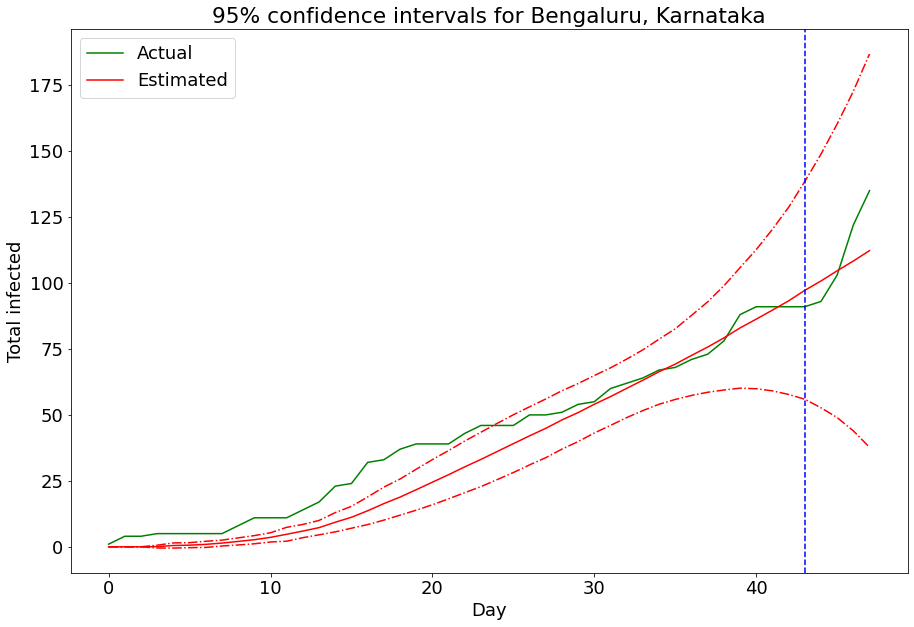

In [20]:
visualize()

## Visualize all runs separately

100%|██████████| 48/48 [00:08<00:00,  5.65it/s]


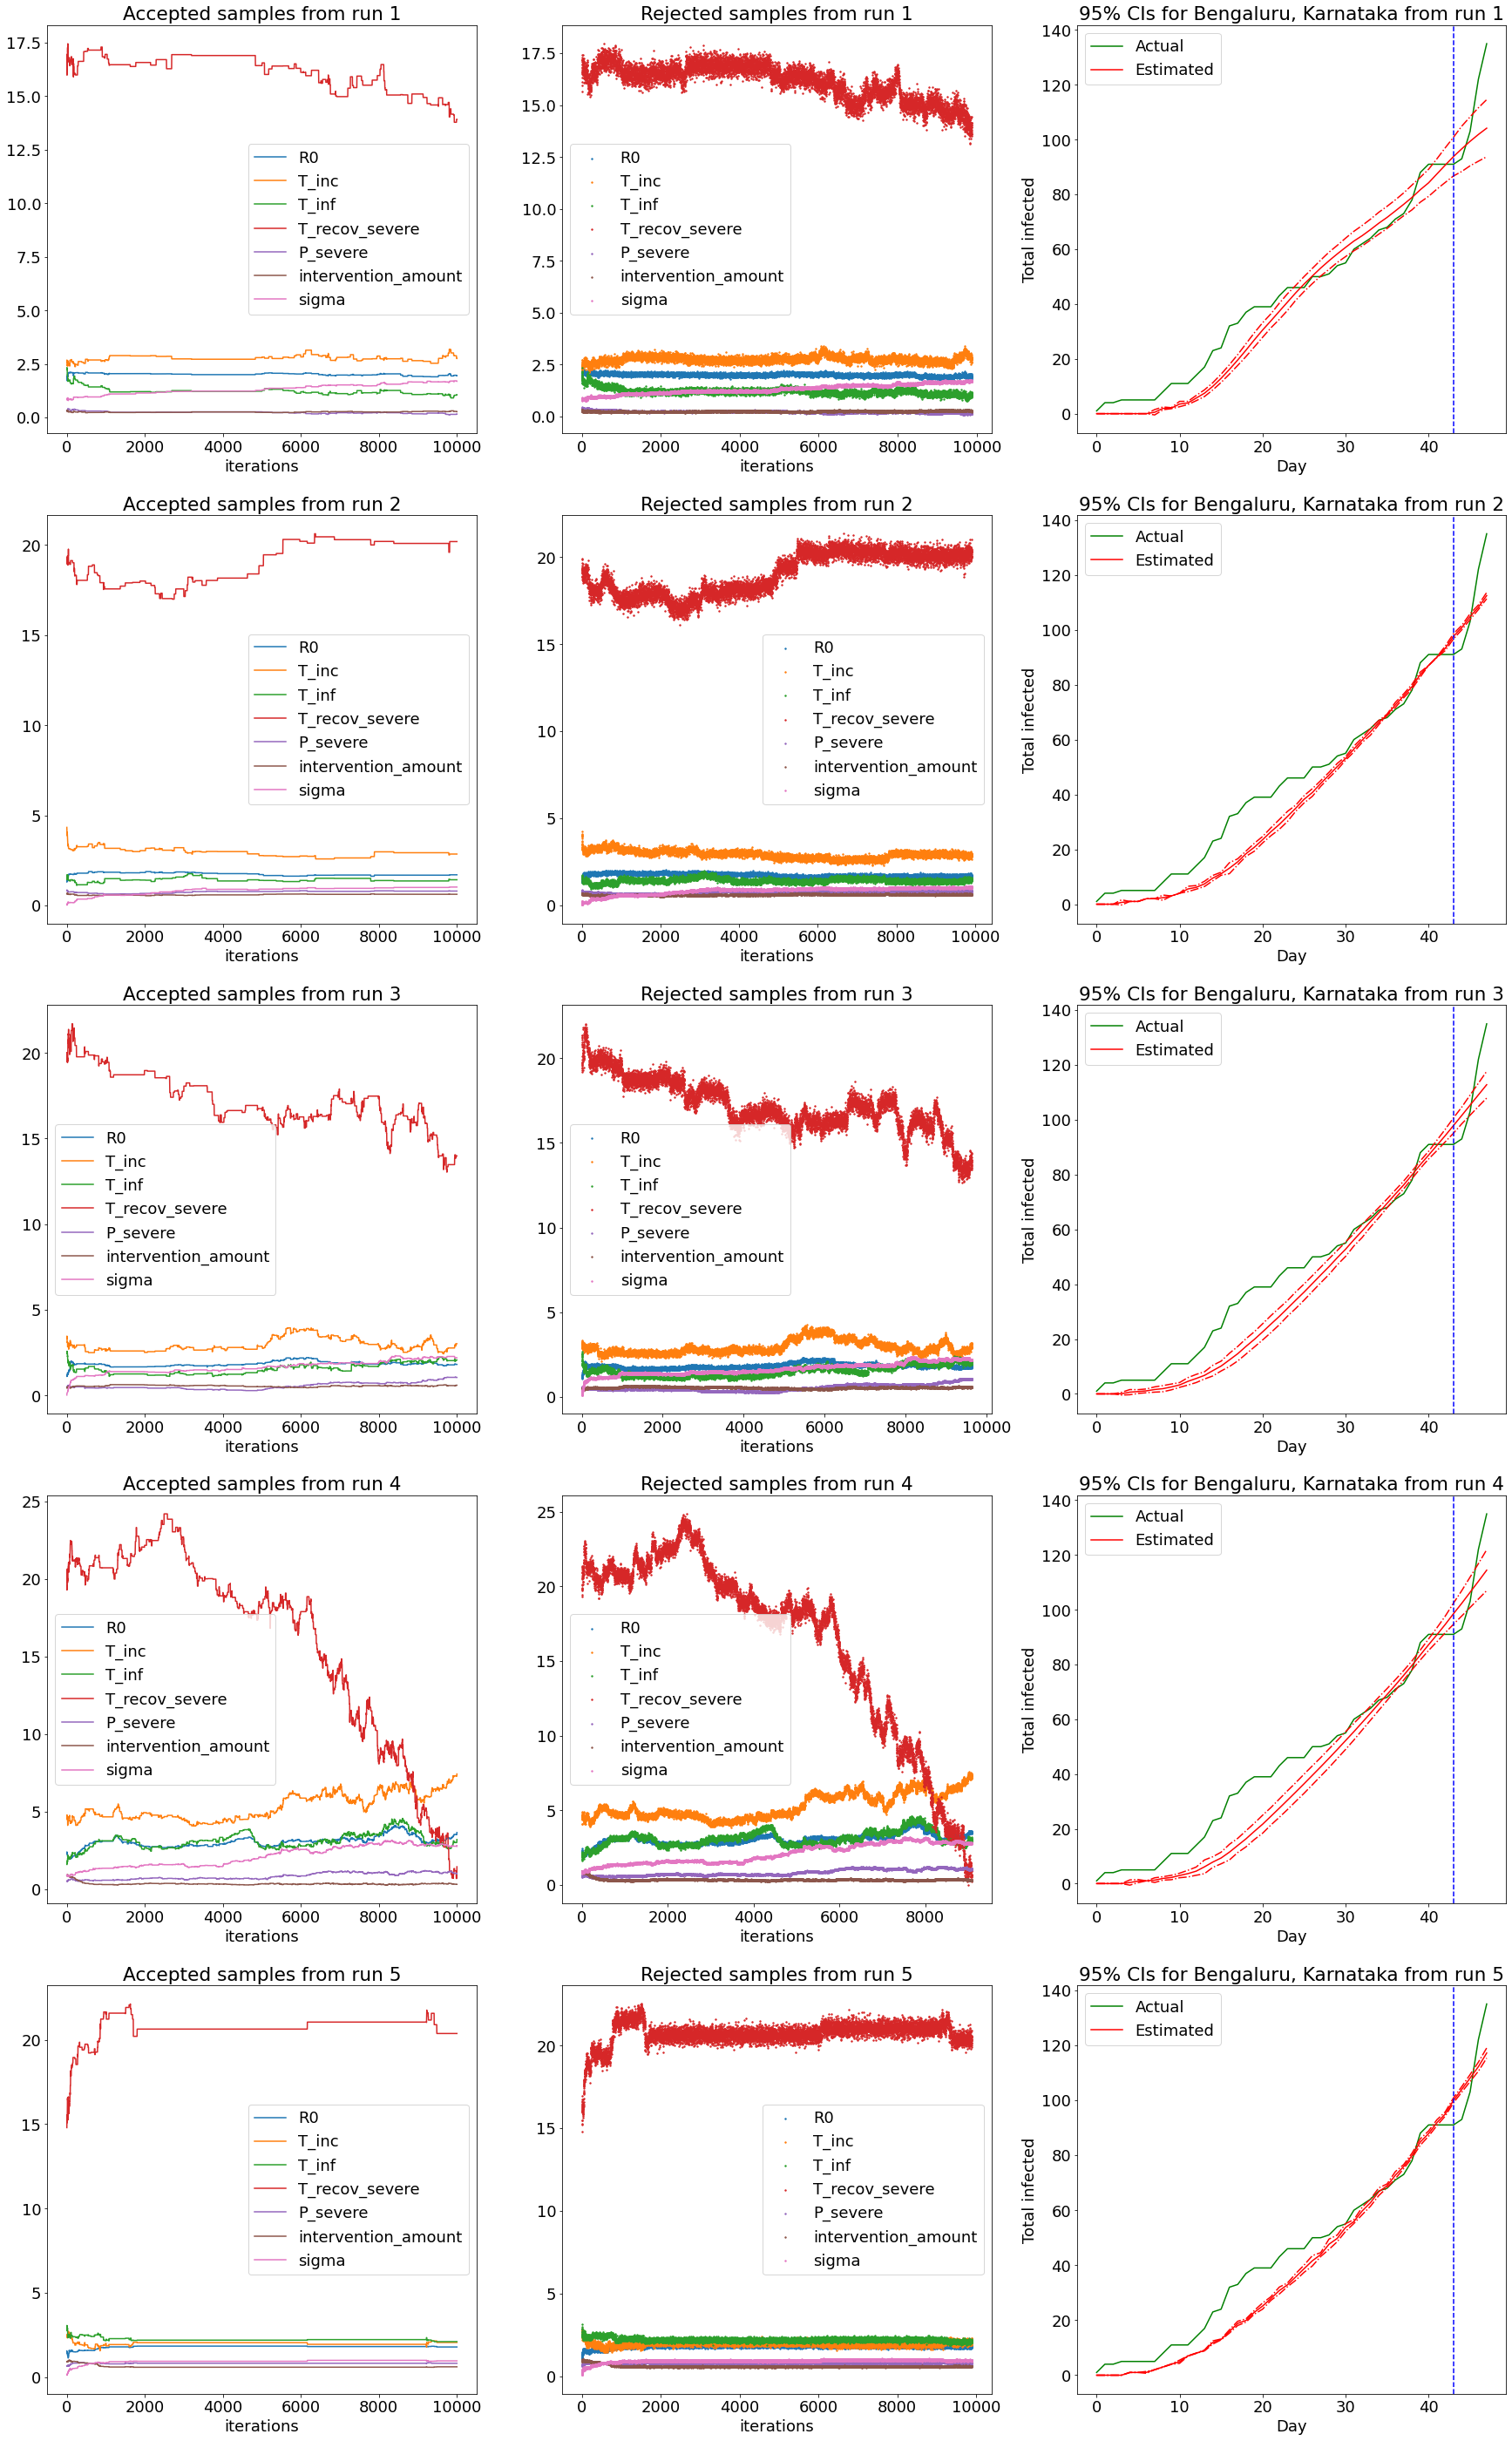

In [21]:
plt.figure(figsize=(30, 50))
    
for k, run in enumerate(mcmc):
    data_split = df_district.copy()
    optimiser = Optimiser()
    default_params = optimiser.init_default_params(data_split)
    
    acc, rej = run[0], run[1]
    df_samples = pd.DataFrame(acc)
    
    plt.subplot(len(mcmc), 3, 3*k + 1)
    for param in df_samples.columns:
        plt.plot(list(range(len(df_samples[param]))), df_samples[param], label=param)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Accepted samples from run {}".format(k+1))
    
    rej_samples = pd.DataFrame(rej)
    
    plt.subplot(len(mcmc), 3, 3*k + 2)
    for param in rej_samples.columns:
        plt.scatter(list(range(len(rej_samples[param]))), rej_samples[param], label=param, s=2)
    plt.xlabel("iterations")
    plt.legend()
    plt.title("Rejected samples from run {}".format(k+1))
    
    burn_in = int(len(acc) / 2)
    n_samples = 1000
    posterior_samples = acc[burn_in:]
    sample_indices = np.random.uniform(0, len(posterior_samples), n_samples)

    pred_dfs = list()
    for i in tqdm(sample_indices):
        pred_dfs.append(optimiser.solve(posterior_samples[int(i)], default_params, data_split))
        
    for df in pred_dfs:
        df.set_index('date', inplace=True)
        
    result = pred_dfs[0].copy()
    for col in result.columns:
        result["{}_low".format(col)] = ''
        result["{}_high".format(col)] = ''
        
    for date in tqdm(pred_dfs[0].index):
        for key in pred_dfs[0]:
            result.loc[date, key], result.loc[date, "{}_low".format(key)], result.loc[date, "{}_high".format(key)] = get_PI(pred_dfs, date, key)
            
    data_split.set_index("date", inplace=True)

    plt.subplot(len(mcmc), 3, 3*k + 3)
    plt.plot(data_split['total_infected'].tolist(), c='g', label='Actual')
    plt.plot(result['total_infected'].tolist(), c='r', label='Estimated')
    plt.plot(result['total_infected_low'].tolist(), c='r', linestyle='dashdot')
    plt.plot(result['total_infected_high'].tolist(), c='r', linestyle='dashdot')
    plt.axvline(x=len(df_train), c='b', linestyle='dashed')
    plt.xlabel("Day")
    plt.ylabel("Total infected")
    plt.legend()
    plt.title("95% CIs for {}, {} from run {}".format(district, state, k+1))
    
plt.savefig("./mcmc_runs_{}_{}.png".format(district, state))
plt.show()


## Checking validity with Gelman-Rubin statistics

Check Section 4.2 [here](http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf)

In [46]:
def accumulate(dict_list):
    accumulator = defaultdict(int)
    for elt in dict_list:
        for key in elt:
            accumulator[key]+=elt[key]
    return accumulator

def divide(dictvar, num):
    return {key:dictvar[key]/num for key in dictvar}

            
def avg_sum_chain(chain):
    chain_sums_avg = accumulate(chain)
    return divide(chain_sums_avg, len(chain))

def avg_sum_multiple_chains(chain_sums_avg):
    multiple_chain_sums_avg = accumulate(chain_sums_avg)
    return divide(multiple_chain_sums_avg, len(chain_sums_avg))

def compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m):
    B = defaultdict(int)
    for elt in chain_sums_avg:
        for key in elt:
            B[key] += np.square(elt[key] - multiple_chain_sums_avg[key])
    return divide(B, (m-1)/n)

def compute_W(split_chains, chain_sums_avg, n, m):
    s = []
    for j in range(m):
        s_j_sq = defaultdict(int)
        chain = split_chains[j]
        chain_sum_avg_j = chain_sums_avg[j]
        for i in range(n):
            chain_elt = chain[i]
            for key in chain_elt:
                s_j_sq[key] += np.square(chain_elt[key] - chain_sum_avg_j [key])
        s_j_sq = divide(s_j_sq, n - 1)
        s.append(s_j_sq)
    return (divide (accumulate(s),m))

def divide_dict(d1, d2):
    accumulator = defaultdict(int)
    for key in d1:
        accumulator[key] = d1[key]/d2[key]
    return accumulator

In [21]:
burn_in = int(len(mcmc[0][0]) / 2)
chains = [mcmc_chain[0] for mcmc_chain in mcmc]
burn_in = int(len(chains[0]) / 2)
sampled_chains = [chain[:burn_in] for chain in chains]
split_chains = [sampled_chain[int(burn_in/2):] for sampled_chain in sampled_chains] \
            + [sampled_chain[:int(burn_in/2)] for sampled_chain in sampled_chains]


In [22]:
chain_sums_avg = []
for chain in split_chains:
    chain_sums_avg.append(avg_sum_chain(chain))
multiple_chain_sums_avg = avg_sum_multiple_chains(chain_sums_avg) 

In [24]:
multiple_chain_sums_avg

{'R0': 2.5046791016357592,
 'T_inc': 3.518743267712472,
 'T_inf': 3.392784608323924,
 'T_recov_severe': 17.912346341867043,
 'P_severe': 0.8223345165008131,
 'intervention_amount': 0.7867461399275144,
 'sigma': 2.192303441475181}

In [56]:
m = len(split_chains)
n = len(split_chains[0])
W =  compute_W(split_chains, chain_sums_avg, n, m)
B =  compute_B(multiple_chain_sums_avg, chain_sums_avg, n, m)
var_hat = accumulate([divide(W, n/(n-1)), divide(B, n) ])
R_hat_sq = divide_dict(var_hat, W)
R_hat = {key:np.sqrt(value) for key, value in R_hat_sq.items()}
neff = divide_dict(var_hat, B)
neff = {key: m*n*value for key, value in neff.items()}

In [57]:
neff

{'R0': 10.458481095152695,
 'T_inc': 10.284714397062823,
 'T_inf': 13.815904443369368,
 'T_recov_severe': 10.549221646044694,
 'P_severe': 10.297853562653573,
 'intervention_amount': 13.141996333774367,
 'sigma': 12.927848178057006}

In [53]:
R_hat

{'R0': 4.775146665181959,
 'T_inc': 6.009032147784898,
 'T_inf': 1.9024096435650102,
 'T_recov_severe': 4.381769314142899,
 'P_severe': 5.878751195481832,
 'intervention_amount': 2.044753487559328,
 'sigma': 2.1008834936533813}